<a href="https://colab.research.google.com/github/snoor-projects/GenAI-Genesis-Toronto/blob/main/Perform_NER_using_Gemini_pro_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Inclusivity with the Gemini Pro Vision Model - Performing NER on MultiLingual Documents


In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

| | |
|-|-|
|Author(s) | [Shubhnoor Gill](https://github.com/snoor-projects), [Siddharth Raja](https://github.com/siddh1990), Shashwat Kumar

## Getting Started


### Install Vertex AI SDK for Python


In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
# Define project information
PROJECT_ID = "enter-project-id"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [ ]:
from vertexai.generative_models import (
    GenerativeModel,
    HarmCategory, #Harm categories that will block the content
    HarmBlockThreshold, #Probability based thresholds levels for blocking
    Image, #The image that can be sent to a generative model
    Part, #A part of a multi-part Content message
)

## Use the Gemini 1.0 Pro Vision model

Gemini 1.0 Pro Vision (`gemini-1.0-pro-vision`) is a multimodal model that supports multimodal prompts. You can include text, image(s), and video in your prompt requests and get text or code responses.


### Load the Gemini 1.0 Pro Vision model


In [ ]:
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

### Define helper functions

Define helper functions to load and display images.


In [ ]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def get_url_from_gcs(gcs_uri: str) -> str:
    # converts gcs uri to url for image display.
    url = "https://storage.googleapis.com/" + gcs_uri.replace("gs://", "").replace(
        " ", "%20"
    )
    return url


def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_images([content])
        elif isinstance(content, Part):
            url = get_url_from_gcs(content.file_data.file_uri)
            IPython.display.display(load_image_from_url(url))
        else:
            print(content)

### Upload an Image from Local Storage

In [ ]:
safety_settings = {
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
}

Welcome to the Loan Application Details Extraction Chat!
Please upload an image of one of the personal identification document.


Saving bihar_certificate.jpg to bihar_certificate.jpg
Processing...
-------Your Uploaded Image --------


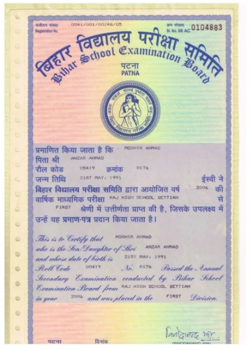

Translate to English. Then extract important details given below in json format.     If the key or value is not present mention it as NA. Extract the following details:    name, age, date of birth, address, father's or husband's name, mother's name, phone number and any other fields you think are relevant while applying for a loan.
Extracted details:
 The image is a certificate of secondary education from the Bihar School Examination Board. The following details are present in the image:

name: MOSHIR AHMAD
age: 15 years
date of birth: 21st May 1991
address: NA
father's or husband's name: ANZAR AHMAD
mother's name: NA
phone number: NA
other fields: roll code: 05419, registration number: 0541/001/00248/05, school name: RAJ HIGH SCHOOL BETTIAH, year of passing: 2006, division: FIRSTDo you want to extract details from another image? (yes/no): yes
Please upload an image of one of the personal identification document.


Saving urdu_certificate_handwritten.png to urdu_certificate_handwritten.png
Processing...
-------Your Uploaded Image --------


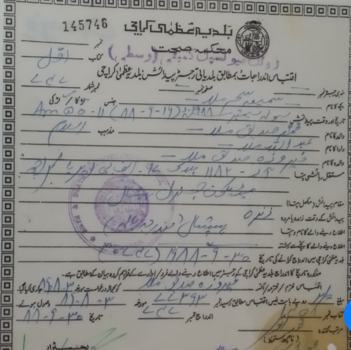

Translate to English. Then extract important details given below in json format.     If the key or value is not present mention it as NA. Extract the following details:    name, age, date of birth, address, father's or husband's name, mother's name, phone number and any other fields you think are relevant while applying for a loan.
Extracted details:
 The image is a birth certificate issued by the Municipal Corporation of Karachi, Pakistan. It is for a baby girl named Samia, born on September 11, 1988. Her father's name is Muhammad Siddique Mallah, her mother's name is Fauzia Siddique Mallah, and her grandfather's name is Abdullah Mallah. The family lives at 1184 Block 96 FB Area, Orangi Town, Karachi.

Here is the extracted data in JSON format:

```
{
  "name": "Samia",
  "age": "NA",
  "date_of_birth": "September 11, 1988",
  "address": "1184 Block 96 FB Area, Orangi Town, Karachi",
  "father's_name": "Muhammad Siddique Mallah",
  "mother's_name": "Fauzia Siddique Mallah",
  "grandfa

Saving portuguese_image.png to portuguese_image.png
Processing...
-------Your Uploaded Image --------


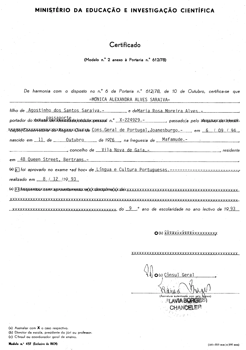

Translate to English. Then extract important details given below in json format.     If the key or value is not present mention it as NA. Extract the following details:    name, age, date of birth, address, father's or husband's name, mother's name, phone number and any other fields you think are relevant while applying for a loan.
Extracted details:
 The text is in Portuguese. It is a certificate of a language proficiency exam. The certificate holder's name is Monica Alexandra Alves Saraiva, and she was born on October 11, 1976, in Vila Nova de Gaia, Portugal. Her father's name is Agostinho dos Santos Saraiva, and her mother's name is Maria Rosa Moreira Alves. Her passport number is X-224929, and it was issued on September 6, 1994, by the Portuguese Consulate General in Johannesburg, South Africa. She currently resides at 4B Queen Street, Bertrams, South Africa.

{
  "name": "Monica Alexandra Alves Saraiva",
  "age": 47,
  "date_of_birth": "October 11, 1976",
  "address": "4B Queen St

In [ ]:
import os
from google.colab import files

def chat_interface():
  print("Welcome to the Loan Application Details Extraction Chat!")
  while True:
    print("Please upload an image of one of the personal identification document.")

    # Upload image
    uploaded_image = files.upload()
    img_name = list(uploaded_image.keys())[0]

    # Load from local file
    image = Image.load_from_file(img_name)

    print("Processing...")

    # Prompt for translation and extraction
    prompt = "Translate to English. Then extract important details given below in json format. \
    If the key or value is not present mention it as NA. Extract the following details:\
    name, age, date of birth, address, father's or husband's name, mother's name, phone number \
    and any other fields you think are relevant while applying for a loan."

    print("-------Your Uploaded Image --------")
    contents = [image, prompt]
    print_multimodal_prompt(contents)

    # Generate response
    responses = multimodal_model.generate_content(contents, safety_settings=safety_settings, stream=True)

    # Print extracted details
    print("Extracted details:")
    for response in responses:
      print(response.text, end="")

    # Ask if user wants to continue

    choice = input("Do you want to extract details from another image? (yes/no): ").strip().lower()
    if choice == 'yes':
      os.remove(img_name)
      continue
    elif choice == 'no':
      os.remove(img_name)
      print("Thank you for using our service!")
      break
    else:
      print("\nInvalid choice. Please enter 'yes' or 'no'.")

# Start the chat interface
chat_interface()

### Reference of Images for training and verifying our model

- Urdu Birth Certificate: https://www.urdutrans.com/portfolio-items/birth-certificate-translation

- Bihar School Examination Board certificate: https://www.slideshare.net/MoshirAhmad/matric-certificate-46861557

- Portuguese Certificate: https://www.slideshare.net/MonicaSaraiva1/portuguese-certificate